### 4: Spatial Estimation via Kriging

Estimating spatial variables using kriging.

In [1]:
# Import Packages/Libraries
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python 
import pandas as pd
import seaborn as sns
import numpy as np                        # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
from scipy import stats                   # summary statistics
import astropy.convolution.convolve as convolve
import scipy.signal as signal             # kernel for moving window calculation
import math                               # trig etc.

### Load in NScored DataFrames

In [2]:
df = pd.read_csv('df_nscored.csv')
df_sand = pd.read_csv('dfsand_nscored.csv')
df_shale = pd.read_csv('dfshale_nscored.csv')

### Load in the variogram models

In [3]:
ind_vario = np.load('indicatorvariogram.npy').item()
sandpor_vario = np.load('sandporosityvariogram.npy').item()
shalepor_vario = np.load('shaleporosityvariogram.npy').item()
sandperm_vario = np.load('sandpermeabilityvariogram.npy').item()
shaleperm_vario = np.load('shalepermeabilityvariogram.npy').item()

### Load the property trends

In [22]:
por_trend = np.load('porositytrend.npy')
perm_trend = np.load('permeabilitytrend.npy')

### Indicator Kriging

In [14]:
plt.rc('xtick',labelsize=28)
plt.rc('ytick',labelsize=28)
plt.rc('axes', titlesize=30)
plt.rc('axes', labelsize=30)
plt.rc('figure', titlesize=30)
plt.rc('legend', fontsize=28)

In [5]:
# basic IK parameters
nxdis = 1; nydis = 1                       # block kriging discretizations, 1 for point kriging
ndmin = 0; ndmax = 10                      # minimum and maximum data for kriging 
radius = 100                               # maximum search distance
ktype = 1                                  # kriging type, 0 - simple, 1 - ordinary
ivtype = 0                                 # variable type, 0 - categorical, 1 - continuous
tmin = -999; tmax = 999;                   # data trimming limits
# additional grid parameters
xmin = 0.0; xmax = 1000.0               # range of x values
ymin = 0.0; ymax = 1000.0               # range of y values
xsiz = 10; ysiz = 10                    # cell size
nx = 100; ny = 100                      # number of cells
xmn = 5; ymn = 5                        # grid origin, location center of lower left cell

In [6]:
# applying the fit model variograms
ncut = 2                                   # number of facies
thresh = [0,1]                             # the facies categories
gcdf = [0.76,0.24]                           # the global proportions of the categories
varios = []                                # the variogram list
varios.append(ind_vario) # shale indicator variogram
varios.append(ind_vario) # sand indicator variogram

In [7]:
# do indicator kriging
no_trend = np.zeros((1,1))                  # null ndarray not of correct size so ik2d will not use a trend - will fix this
ikmap = geostats.ik2d(df,'X','Y','Facies',ivtype,0,2,
                      thresh,gcdf,no_trend,tmin,tmax,
                      nx,xmn,xsiz,ny,ymn,ysiz, ndmin,ndmax,
                      radius,ktype,vario=varios)

Data for IK3D: Variable column Facies
  Number   = 217
Setting up rotation matrices for variogram and search
Working on the kriging
   currently on estimate 0
   currently on estimate 1000
   currently on estimate 2000
   currently on estimate 3000
   currently on estimate 4000
   currently on estimate 5000
   currently on estimate 6000
   currently on estimate 7000
   currently on estimate 8000
   currently on estimate 9000


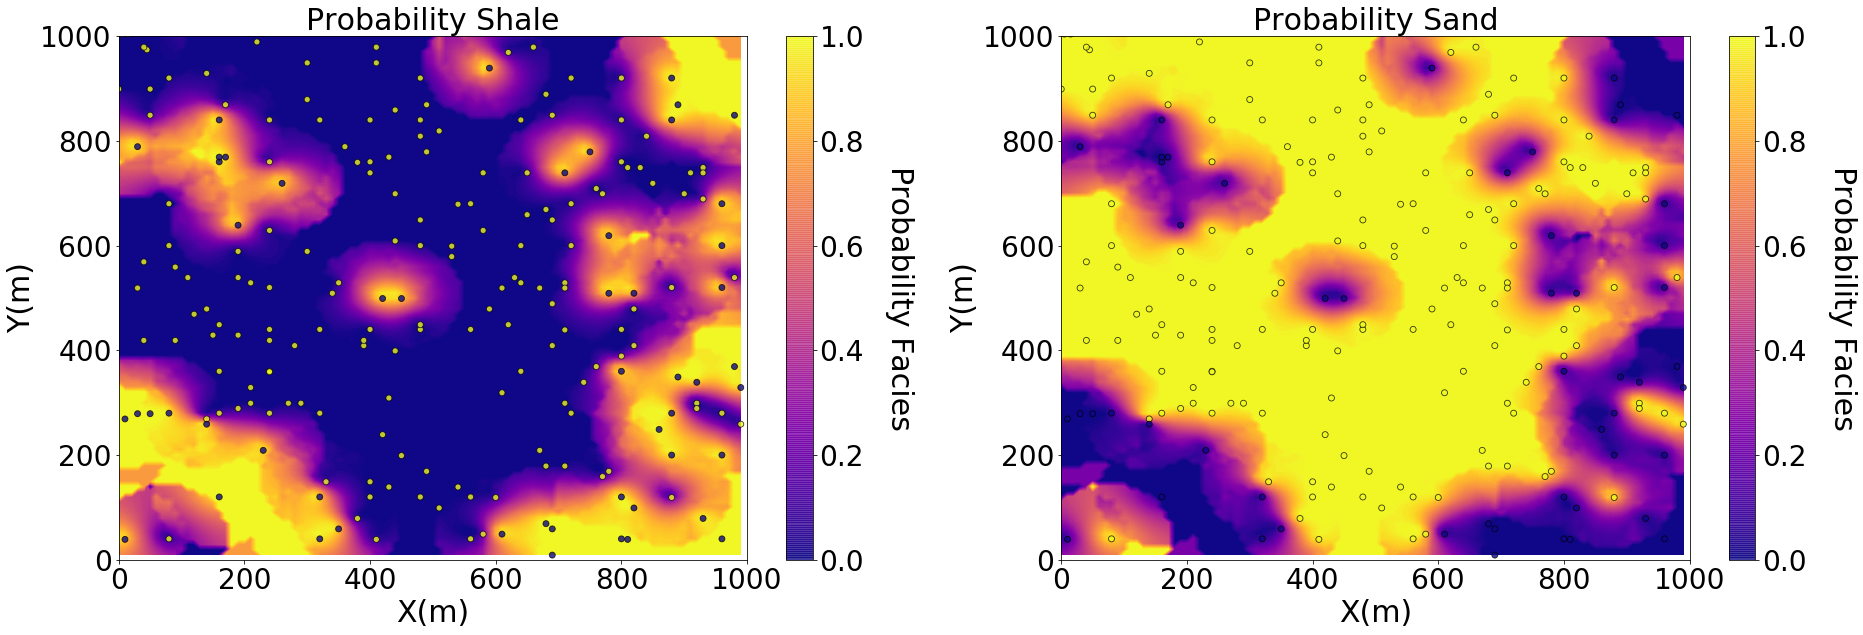

In [15]:
# plotting indicator kriging
cmap = plt.cm.plasma
plt.subplot(221) 
GSLIB.locpix_st(ikmap[:,:,0],xmin,xmax,ymin,ymax,xsiz,0.0,1.0,
                df,'X','Y','Facies','Probability Shale','X(m)','Y(m)','Probability Facies',cmap)
cbar = plt.gci().colorbar
cbar.set_label('Probability Facies', labelpad = 50)

plt.subplot(222) 
GSLIB.locpix_st(ikmap[:,:,1],xmin,xmax,ymin,ymax,xsiz,0.0,1.0,
                df,'X','Y','Facies','Probability Sand','X(m)','Y(m)','Probability Facies',cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=4.0, wspace=0.2, hspace=0.2)
cbar = plt.gci().colorbar
cbar.set_label('Probability Facies', labelpad = 50)

plt.show()

### Sandstone Porosity

In [81]:
# sandstone porosity SK
skmean_por = df_sand['Por_Res'].mean()
skmean_perm = df_sand['Perm_Res'].mean()   # simple kriging mean (used if simple kriging is selected below)
ktype = 0                                  # kriging type, 0 - simple, 1 - ordinary
radius = 100                               # search radius for neighbouring data
nxdis = 1; nydis = 1                       # number of grid discretizations for block kriging (not tested)
ndmin = 0; ndmax = 10                      # minimum and maximum data for an estimate
tmin = -1.0                                # minimum property value
tmax = 9999
xmin = 0.0; xmax = 1000.0               # range of x values
ymin = 0.0; ymax = 1000.0               # range of y values
xsiz = 10; ysiz = 10                    # cell size
nx = 100; ny = 100                      # number of cells
xmn = 5; ymn = 5                        # grid origin, location center of lower left cell

sandpor_kmap, sandpor_vmap = geostats.kb2d(df_sand,'X','Y','Por_Res',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_por,sandpor_vario)

  Estimated   10000 blocks 
      average   0.004939174710171522  variance  2.4125153576810364e-05


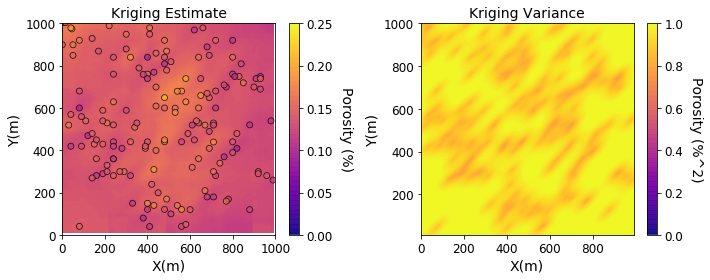

In [82]:
# plot SK for sandstone porosity
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=14)
plt.rc('figure', titlesize=14)
plt.rc('legend', fontsize=12)

plt.figure(figsize=(10,4))

plt.subplot(121)
GSLIB.locpix_st(sandpor_kmap+por_trend,
                xmin,xmax,ymin,ymax,
                xsiz,0.0,0.25,
                df_sand,'X','Y','Porosity',
                'Kriging Estimate','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(122)
GSLIB.pixelplt_st(sandpor_vmap,
                  xmin,xmax,ymin,ymax,
                  xsiz,0.0,1.0,
                  'Kriging Variance','X(m)','Y(m)','Porosity (%^2)',cmap)

plt.tight_layout()
plt.show()

### Sandstone Permeability

In [83]:
# sandstone permeability SK
skmean_por = df_sand['Perm_Res'].mean()
skmean_perm = df_sand['Perm_Res'].mean()   # simple kriging mean (used if simple kriging is selected below)
ktype = 0                                  # kriging type, 0 - simple, 1 - ordinary
radius = 100                               # search radius for neighbouring data
nxdis = 1; nydis = 1                       # number of grid discretizations for block kriging (not tested)
ndmin = 0; ndmax = 10                      # minimum and maximum data for an estimate
tmin = -50.0                               # minimum property value
tmax = 9999
xmin = 0.0; xmax = 1000.0               # range of x values
ymin = 0.0; ymax = 1000.0               # range of y values
xsiz = 10; ysiz = 10                    # cell size
nx = 100; ny = 100                      # number of cells
xmn = 5; ymn = 5                        # grid origin, location center of lower left cell

sandperm_kmap, sandperm_vmap = geostats.kb2d(df_sand,'X','Y','Perm_Res',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_perm,sandperm_vario)

  Estimated   10000 blocks 
      average   4.360170710096116  variance  81.65145705790357


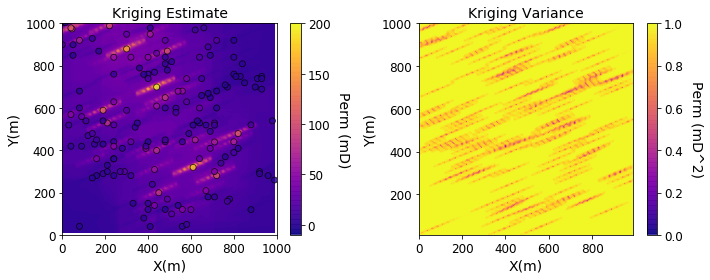

In [84]:
# plot SK for sandstone permeability
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=14)
plt.rc('figure', titlesize=14)
plt.rc('legend', fontsize=12)

plt.figure(figsize=(10,4))

plt.subplot(121)
GSLIB.locpix_st(sandperm_kmap+perm_trend,
                xmin,xmax,ymin,ymax,
                xsiz,-10.0,200.0,
                df_sand,'X','Y','Perm',
                'Kriging Estimate','X(m)','Y(m)','Perm (mD)',cmap)

plt.subplot(122)
GSLIB.pixelplt_st(sandperm_vmap,
                  xmin,xmax,ymin,ymax,
                  xsiz,0.0,1.0,
                  'Kriging Variance','X(m)','Y(m)','Perm (mD^2)',cmap)

plt.tight_layout()
plt.show()

### Shale Porosity

In [85]:
# shale porosity SK
skmean_por = df_shale['Por_Res'].mean()
skmean_perm = df_shale['Perm_Res'].mean()   # simple kriging mean (used if simple kriging is selected below)
ktype = 0                                  # kriging type, 0 - simple, 1 - ordinary
radius = 100                               # search radius for neighbouring data
nxdis = 1; nydis = 1                       # number of grid discretizations for block kriging (not tested)
ndmin = 0; ndmax = 10                      # minimum and maximum data for an estimate
tmin = -1.0                                # minimum property value
tmax = 9999
xmin = 0.0; xmax = 1000.0               # range of x values
ymin = 0.0; ymax = 1000.0               # range of y values
xsiz = 10; ysiz = 10                    # cell size
nx = 100; ny = 100                      # number of cells
xmn = 5; ymn = 5                        # grid origin, location center of lower left cell

shalepor_kmap, shalepor_vmap = geostats.kb2d(df_shale,'X','Y','Por_Res',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_por,sandpor_vario)

  Estimated   10000 blocks 
      average   -0.013469049497532836  variance  1.1519512135929974e-05


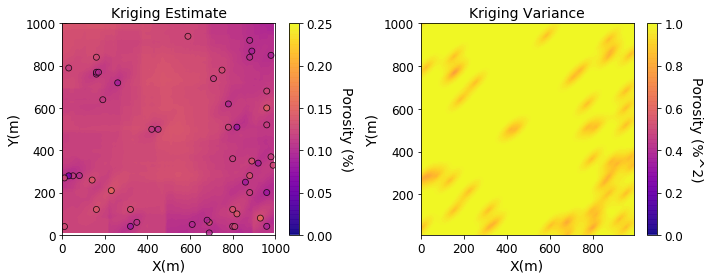

In [86]:
# plot SK for shale porosity
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=14)
plt.rc('figure', titlesize=14)
plt.rc('legend', fontsize=12)

plt.figure(figsize=(10,4))

plt.subplot(121)
GSLIB.locpix_st(shalepor_kmap+por_trend,
                xmin,xmax,ymin,ymax,
                xsiz,0.0,0.25,
                df_shale,'X','Y','Porosity',
                'Kriging Estimate','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(122)
GSLIB.pixelplt_st(shalepor_vmap,
                  xmin,xmax,ymin,ymax,
                  xsiz,0.0,1.0,
                  'Kriging Variance','X(m)','Y(m)','Porosity (%^2)',cmap)

plt.tight_layout()
plt.show()

### Shale Permeability

In [87]:
# shale permeability SK
skmean_por = df_shale['Perm_Res'].mean()
skmean_perm = df_shale['Perm_Res'].mean()   # simple kriging mean (used if simple kriging is selected below)
ktype = 0                                  # kriging type, 0 - simple, 1 - ordinary
radius = 100                               # search radius for neighbouring data
nxdis = 1; nydis = 1                       # number of grid discretizations for block kriging (not tested)
ndmin = 0; ndmax = 10                      # minimum and maximum data for an estimate
tmin = -50.0                               # minimum property value
tmax = 9999
xmin = 0.0; xmax = 1000.0               # range of x values
ymin = 0.0; ymax = 1000.0               # range of y values
xsiz = 10; ysiz = 10                    # cell size
nx = 100; ny = 100                      # number of cells
xmn = 5; ymn = 5                        # grid origin, location center of lower left cell

shaleperm_kmap, shaleperm_vmap = geostats.kb2d(df_shale,'X','Y','Perm_Res',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_perm,sandperm_vario)

  Estimated   10000 blocks 
      average   -8.782091487299695  variance  1.4278007443307388


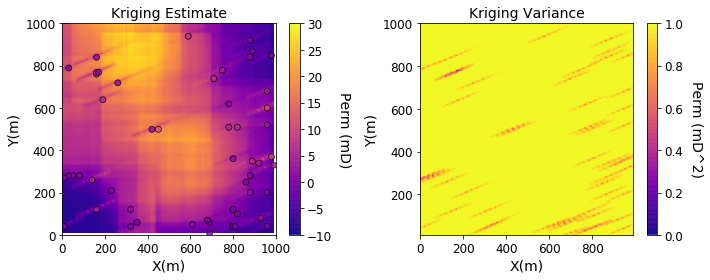

In [88]:
# plot SK for shale permeability
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=14)
plt.rc('figure', titlesize=14)
plt.rc('legend', fontsize=12)

plt.figure(figsize=(10,4))

plt.subplot(121)
GSLIB.locpix_st(shaleperm_kmap+perm_trend,
                xmin,xmax,ymin,ymax,
                xsiz,-10.0,30.0,
                df_shale,'X','Y','Perm',
                'Kriging Estimate','X(m)','Y(m)','Perm (mD)',cmap)

plt.subplot(122)
GSLIB.pixelplt_st(shaleperm_vmap,
                  xmin,xmax,ymin,ymax,
                  xsiz,0.0,1.0,
                  'Kriging Variance','X(m)','Y(m)','Perm (mD^2)',cmap)

plt.tight_layout()
plt.show()

### Cookie-Cutter Kriging

In [89]:
facies_kmap = np.zeros((ny,nx))
por_kmap = np.zeros((ny,nx)); perm_kmap = np.zeros((ny,nx)) # declare array to combine values

for iy in range(0,ny):
    for ix in range(0,nx):
        if ikmap[iy,ix,1] > 0.5:   # current location is assumed to be sand
            facies_kmap[iy,ix] = 1
            por_kmap[iy,ix] = sandpor_kmap[iy,ix] + por_trend[iy,ix];
            perm_kmap[iy,ix] = sandperm_kmap[iy,ix] + perm_trend[iy,ix];
            if perm_kmap[iy,ix] < 0:
                perm_kmap[iy,ix] = 0.0
            shalepor_kmap[iy,ix] = -1
            shaleperm_kmap[iy,ix] = -1
        else:                      # current location is assumed to be shale
            facies_kmap[iy,ix] = 0
            por_kmap[iy,ix] = shalepor_kmap[iy,ix] + por_trend[iy,ix];
            perm_kmap[iy,ix] = shaleperm_kmap[iy,ix] + perm_trend[iy,ix];
            if perm_kmap[iy,ix] < 0:
                perm_kmap[iy,ix] = 0.0
            sandpor_kmap[iy,ix] = -1
            sandperm_kmap[iy,ix] = -1

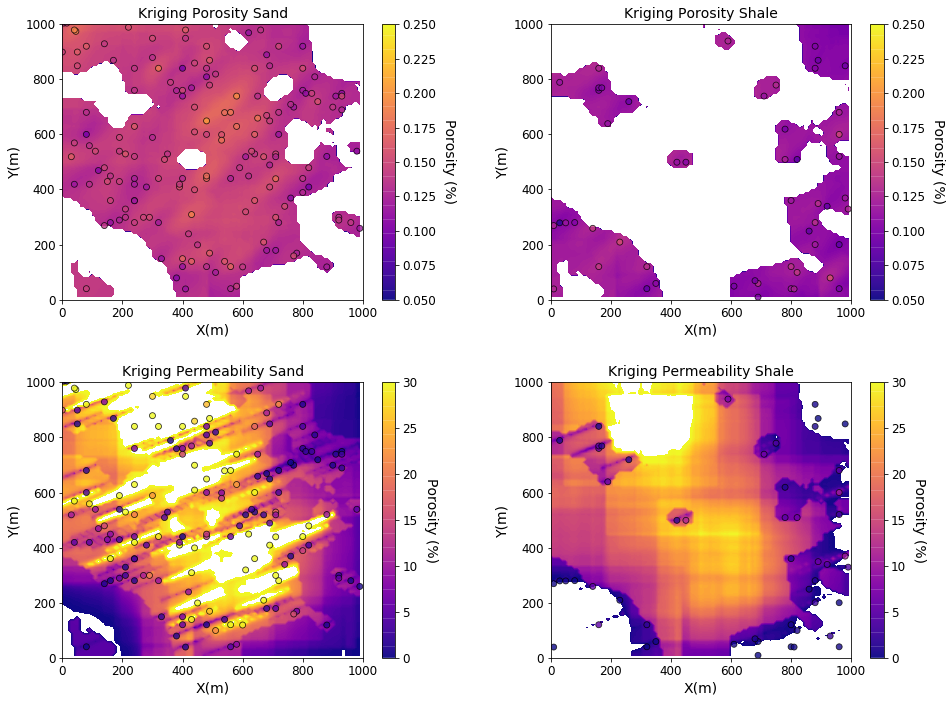

In [90]:
# cookie parts
plt.subplot(221)
GSLIB.locpix_st(sandpor_kmap+por_trend,
                xmin,xmax,ymin,ymax,xsiz,0.05,0.25,
                df_sand,'X','Y','Porosity','Kriging Porosity Sand','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(222)
GSLIB.locpix_st(shalepor_kmap+por_trend,
                xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df_shale,
                'X','Y','Porosity','Kriging Porosity Shale','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(223)
GSLIB.locpix_st(sandperm_kmap+perm_trend,
                xmin,xmax,ymin,ymax,xsiz,0.0,30,df_sand,
                'X','Y','Perm','Kriging Permeability Sand','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(224)
GSLIB.locpix_st(shaleperm_kmap+perm_trend,
                xmin,xmax,ymin,ymax,xsiz,0.0,30,df_shale,
                'X','Y','Perm','Kriging Permeability Shale','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.3, hspace=0.3)
plt.show()

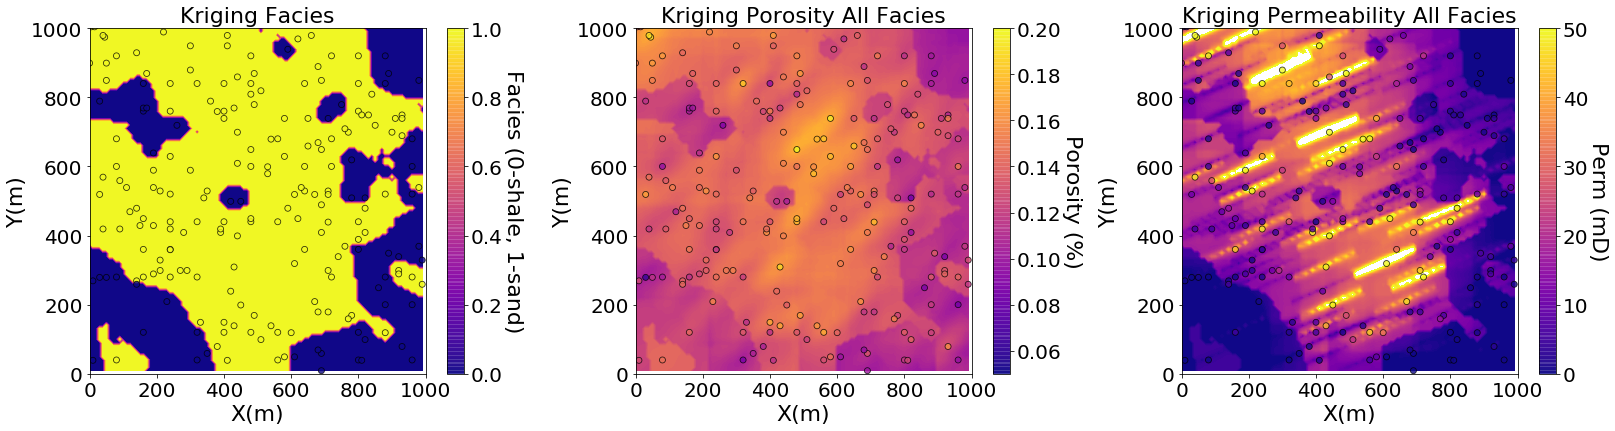

In [96]:
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.rc('axes', titlesize=22)
plt.rc('axes', labelsize=22)
plt.rc('figure', titlesize=20)
plt.rc('legend', fontsize=22)

plt.subplot(131)
GSLIB.locpix_st(facies_kmap,xmin,xmax,ymin,ymax,xsiz,0,1,df,'X','Y','Facies','Kriging Facies','X(m)','Y(m)','Facies (0-shale, 1-sand)',cmap)

plt.subplot(132)
GSLIB.locpix_st(por_kmap,xmin,xmax,ymin,ymax,xsiz,0.05,0.20,df,'X','Y','Porosity','Kriging Porosity All Facies','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(133)
GSLIB.locpix_st(perm_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,50,df,'X','Y','Perm','Kriging Permeability All Facies','X(m)','Y(m)','Perm (mD)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.5, top=1.2, wspace=0.3, hspace=0.3)
plt.show()

## Save Kriging Results

In [97]:
np.save('indicatorkriging.npy',facies_kmap)
np.save('sandporkriging.npy',sandpor_kmap)
np.save('sandpermkriging.npy',sandperm_kmap)
np.save('shaleporkriging.npy',shalepor_kmap)
np.save('shalepermkriging.npy',shaleperm_kmap)